[前回](http://hkwi.github.io/kobe-barcelona/app/2016/10/02/preschool-map.html) 5 歳について、待機児童激戦区を求めたので、同様に 0～5歳のマップを求める。

ルーチン化して使う。

In [1]:
import re
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy.spatial
import functools
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon

In [2]:
import unittest
T=unittest.TestCase()

In [3]:
# こども園の最新のデータを分析する。
nib_ = gpd.read_file("../data/hkwi/shinseido-2016-09.json")
# そのまま集計すると、分園の数だけ二重に集計してしまう
nib = nib_[nib_["状況,参照"]!="本園"]

#"状況,利用定員（２・３号）"は本園に合算されているので使わない
k1 = ["状況,合計", "１号,認可定員(全体)", "２号３号,利用定員（2・3号）"]
k2 = ["状況,申込児童数 %s歳児" % "０１２３４５"[i] for i in range(6)]
k3 = ["%d歳" % i for i in range(6)]
k4 = ["状況,入所の可能性 %s歳児" % i for i in "０１２３４５"]

# nib のセルのいくつかは数値に補足情報が付いているので、除去する
def drop_notes(c):
    if c is not None and len(c):
        m = re.match(r'^(\d+)\s*[（\()]内地域枠\d+[）\)]$', c)
        if m:
            return int(m.group(1))
        elif c[-1] in "*＊":
            return int(c[:-1])
        else:
            return int(c)
    return None

nib_ = nib[k1+k2].applymap(drop_notes)
nib = nib.assign(**{k:nib_[k] for k in k1+k2})

# 同一住所に複数の施設が存在したりするので、まず位置情報だけで分割できるようにする。
coords_nib = [r.coords[0] for _,r in nib.geometry.iteritems()]
coords = []
for c in coords_nib:
    if c not in coords:
        coords.append(c)

pts = gpd.GeoDataFrame([{"geometry":Point(x,y)} for x,y in coords], crs="+init=epsg:4326")
nib_pti = pd.Series([coords.index(c) for c in coords_nib], index=nib.index, name="pti")


# e-Stat の区域データを読み込む。
us = [gpd.read_file(f) for f in glob.glob("../data/estat/h22ka281*.shp")]
pib_ = gpd.GeoDataFrame(pd.concat(us, ignore_index=True), crs=us[0].crs)
pib = pib_[(pib_["MOJI"]!="水面") & (pib_["MOJI"].isnull()==False)] # 海上を取り除く

be = [("minx",min), ("miny",min), ("maxx",max), ("maxy",max)]
pib_ext = [Point([be[j][1](pib.bounds[be[j][0]]) for j in i]) for i in ((0,1),(2,1),(2,3),(0,3))]


# 神戸市の人口データを読み込む。
ages = ["%d歳" % i for i in range(100)]+["100歳以上"]
def load_zensi(fname):
    e = pd.ExcelFile(fname)
    opts = dict(skiprows=1, converters={"区コード":str, "町コード":str})
    dfs = [e.parse(s, **opts).iloc[1:,:] for s in e.sheet_names if s != "神戸市"]
    return pd.DataFrame(pd.concat(dfs, ignore_index=True))

zib_ = load_zensi("../data/kobe/zensi2808.xls")

# 直接 KEYCODE1 が引けるなら、それを採用
zib = zib_.assign(KEYCODE1=lambda df:df["町コード"][df["町コード"].isin(set(pib["KEYCODE1"]))])
# 引けなければ、緯度経度から解決を試みる
qname = zib_.apply(lambda r:"神戸市 %s %s" % (r["区・支所"].replace("支所",""), r["町名"]), axis=1)
try:
    cache = pd.read_json(open("../cache/kobe.json", encoding="UTF-8")).T
except:
    cache = pd.DataFrame([], columns=["lat", "lng"])

qn = pd.DataFrame(qname, columns=["qname"])
qa = qn[zib["町コード"].isin(set(pib["KEYCODE1"]))==False].join(cache, on="qname", how="inner")
pt = gpd.GeoDataFrame(qa.apply(lambda r:Point(r["lng"], r["lat"]), axis=1), columns=["geometry"], crs="+init=epsg:4326")
pt_mv = gpd.tools.sjoin(pt, pib.to_crs("+init=epsg:4326"), op="within")
zib.loc[pt_mv.index, "KEYCODE1"] = pt_mv["KEYCODE1"]

In [4]:
pib_pop = pib.join(
    zib.groupby("KEYCODE1").sum()[k3],
    on="KEYCODE1"
).join(
    pd.concat([pib["KEYCODE1"], pib.geometry.area], axis=1).groupby("KEYCODE1").sum().rename(columns={0:"area_sum"}),
    on="KEYCODE1"
)
for k in k3:
    pib_pop = pib_pop.assign(**{k:lambda d:d[k] * pib_pop.geometry.area / pib_pop["area_sum"]})

In [5]:
for k in k3:
    T.assertAlmostEqual( pib_pop.sum()[k], zib.sum()[k] )

In [6]:
cpib_ = gpd.GeoDataFrame(pd.concat([pib["geometry"],
    pd.Series(pib.index, index=pib.index, name="pib")], axis=1)).assign(one=1)
cpib = gpd.tools.sjoin(cpib_, cpib_, op="intersects")

pib_pop2_ = cpib.join(
    cpib.groupby("pib_left").sum()["one_left"].rename("counts"),
    on="pib_left"
).join(
    pib_pop[k3],
    on="pib_left"
)
for k in k3:
    pib_pop2_[k] = pib_pop2_[k] / pib_pop2_["counts"]
pib_pop2 = pib_pop2_.groupby("pib_right").sum()

合計値の検算をしておきます。

In [7]:
for k in k3:
    T.assertAlmostEqual( pib_pop2.sum()[k], zib.sum()[k] )

In [8]:
# ボロノイ図関連のルーチン
def voronoi(npts):
    # Add extra points to create closed Polygon for all facilities
    ext = []
    for pt in pib_ext:
        dist = npts.distance(pt)
        n = npts[dist==min(dist)].geometry.iloc[0]
        ext.append(Point(pt.x*2 - n.x, pt.y*2 - n.y))

    npts_ext = gpd.GeoDataFrame([dict(geometry=p, dummy=1) for p in ext])
    g = gpd.GeoDataFrame(pd.concat([npts, npts_ext], ignore_index=True))
    v = scipy.spatial.Voronoi([p.coords[0] for i,p in g.geometry.iteritems()])
    return v

def voronoi2region(npts, v, **kwargs):
    vp = [dict(geometry=Polygon([v.vertices[vt] for vt in v.regions[r]]),
            npti=npts.index[i], **kwargs)
        for i,r in enumerate(v.point_region) if -1 not in v.regions[r]]
    assert len(vp) == npts.shape[0]
    return vp

def proc(zib_age, nib_age):
    nibi = (nib[nib_age].isnull()==False)
    nib2 = nib[nibi]

    # CRS は面積の計算できる座標系に揃える。
    pt2 = pts.to_crs(pib.crs).loc[set(nib_pti[nibi])]
    v = voronoi(pt2)
    r2 = gpd.GeoDataFrame(voronoi2region(pt2, v), crs=pib.crs)
    pt2_neigh = pd.DataFrame(np.r_[
        v.ridge_points,
        v.ridge_points.dot(np.array([[0,1],[1,0]])),
        np.array([[i, i] for i in range(len(pt2.index))])
    ], columns=["L","R"]).applymap(
        lambda x:pt2.index[x] if x<len(pt2.index) else None
    ).dropna()

    pib_ = gpd.GeoDataFrame(pd.concat([pib,
        pd.Series(pib.index, index=pib.index, name="pib")], axis=1))
    ta = gpd.overlay(pib_, r2, how="union") # この計算は重い！

    tv = ta[ta["pib"].isnull()==False]
    tv.crs = pib.crs

    tv_pop = tv.join(
        pd.concat([(tv.geometry.area).rename("pib_area"), tv], axis=1).groupby("pib").sum()["pib_area"],
        on="pib"
    ).join(
        pib_pop2[zib_age],
        on="pib"
    ).assign(
        tv_pop = lambda df:df[zib_age] * df.geometry.area / df["pib_area"]
    )
    pti_pop = tv_pop.groupby("npti").sum()["tv_pop"].rename("pti_pop")
    
    pti_neigh_pop_sum = pt2_neigh.join(
        pt2_neigh.join(pti_pop, on="L").groupby("R").sum()["pti_pop"].rename("wide_sum"),
        on="L"
    ).join(
        pti_pop,
        on="R"
    )
    pti_wait = pd.merge(pti_neigh_pop_sum, pd.concat([nib2, nib_pti], axis=1), left_on="L", right_on="pti").assign(
        pti_wait=lambda df:df[nib_age] * df["pti_pop"] / df["wide_sum"]
    ).groupby("R").sum()["pti_wait"]
    
    pti_g_ = [functools.reduce(lambda x,y:x.union(y), tv[tv["npti"]==pti].geometry) for pti in pt2.index]
    pti_g = pd.Series(pti_g_, index=pt2.index, name="geometry")
    return gpd.GeoDataFrame(
        pd.concat([pti_g, (pti_wait/pti_pop).rename("rate")], axis=1),
        crs=pib.crs)

def kml_coords(r):
    ret = []
    if isinstance(r.geometry, MultiPolygon):
        for g in r.geometry.geoms:
            xy = g.exterior.xy
            ret += ["%f,%f" % (x,y) for x,y in zip(xy[0], xy[1])]
    else:
        xy = r.geometry.exterior.xy
        ret += ["%f,%f" % (x,y) for x,y in zip(xy[0], xy[1])]
    
    return "\n".join(ret)

def kmlstr(data):
    out = '''<?xml version="1.0" encoding="UTF-8"?>
    <kml xmlns="http://www.opengis.net/kml/2.2">
      <Document>
        <name>KmlFile</name>'''
    
    rate_max = data["rate"].max()
    coords = data.to_crs("+init=epsg:4326").apply(kml_coords, axis=1)
    for ri,r in data.iterrows():
        c = matplotlib.pyplot.cm.YlOrRd(r["rate"]/rate_max)
        out += '''
    <Style id="color%d">
    <LineStyle><width>1.0</width></LineStyle>
    <PolyStyle><color>%02x%02x%02x%02x</color><colorMode>normal</colorMode></PolyStyle>
    </Style>''' % (ri, int(255*c[3]), int(255*c[2]), int(255*c[1]), int(255*c[0]))
        out += '''
    <Placemark>
    <name>%d</name>
    <visibility>1</visibility>
    <styleUrl>#color%d</styleUrl>
    <Polygon>
    <tessellate>1</tessellate>
    <outerBoundaryIs>
      <LinearRing>
        <coordinates>
    %s
        </coordinates>
      </LinearRing>
    </outerBoundaryIs>
    </Polygon>
    </Placemark>''' % (ri, ri, coords[ri])

    out+='''</Document></kml>'''
    return out

def kmlextra(data):
    rate_max = data["rate"].max()
    def color(r):
        if r["rate"]==0:
            return "#00000000"
        t = matplotlib.pyplot.cm.YlOrRd(r["rate"]/rate_max)
        return "#%02x%02x%02x60" % tuple(map(lambda r:int(r*255), t[:3]))
    
    return pd.concat([pd.Series(data.index, index=data.index, name="hint").apply(lambda x:str(int(x))),
        pd.Series([", ".join([j for j in nib[nib_pti==i]["状況,施設名"] if j]) for i in data.index], index=data.index, name="施設名"),
        data.geometry.area,
        data.apply(color, axis=1)], axis=1)


In [9]:
%matplotlib inline

## 0歳

In [10]:
g = proc("0歳", "状況,申込児童数 ０歳児").dropna()

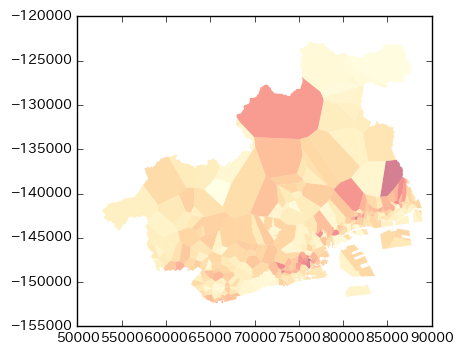

In [11]:
_ = g.plot(column="rate", cmap="YlOrRd", linewidth=0)
_ = open("../docs/data/2016-10-03-preschool-0.kml","w",encoding="UTF-8").write(kmlstr(g))
_ = open("../docs/data/2016-10-03-preschool-0.csv","w",encoding="UTF-8").write(kmlextra(g).to_csv())

## 1歳

In [12]:
g = proc("1歳", "状況,申込児童数 １歳児").dropna()

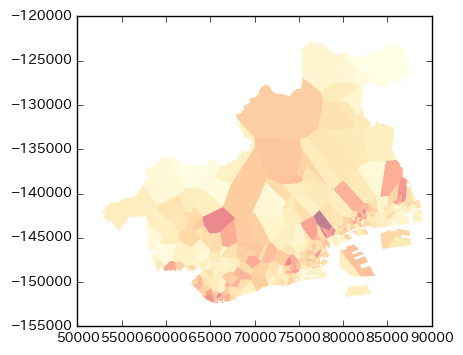

In [13]:
_ = g.plot(column="rate", cmap="YlOrRd", linewidth=0)
_ = open("../docs/data/2016-10-03-preschool-1.kml","w",encoding="UTF-8").write(kmlstr(g))
_ = open("../docs/data/2016-10-03-preschool-1.csv","w",encoding="UTF-8").write(kmlextra(g).to_csv())

## 2歳

In [14]:
g = proc("2歳", "状況,申込児童数 ２歳児").dropna()

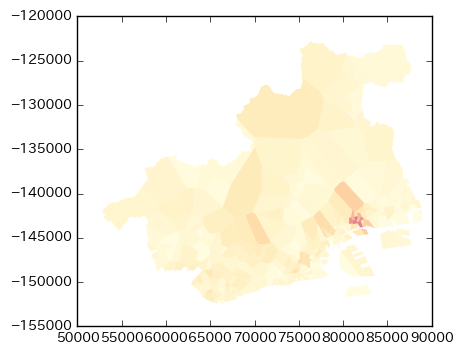

In [15]:
_ = g.plot(column="rate", cmap="YlOrRd", linewidth=0)
_ = open("../docs/data/2016-10-03-preschool-2.kml","w",encoding="UTF-8").write(kmlstr(g))
_ = open("../docs/data/2016-10-03-preschool-2.csv","w",encoding="UTF-8").write(kmlextra(g).to_csv())

## 3歳

In [16]:
g = proc("3歳", "状況,申込児童数 ３歳児").dropna()

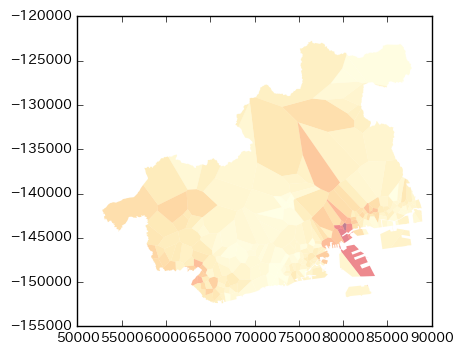

In [17]:
_ = g.plot(column="rate", cmap="YlOrRd", linewidth=0)
_ = open("../docs/data/2016-10-03-preschool-3.kml","w",encoding="UTF-8").write(kmlstr(g))
_ = open("../docs/data/2016-10-03-preschool-3.csv","w",encoding="UTF-8").write(kmlextra(g).to_csv())

## 4歳

In [18]:
g = proc("4歳", "状況,申込児童数 ４歳児").dropna()

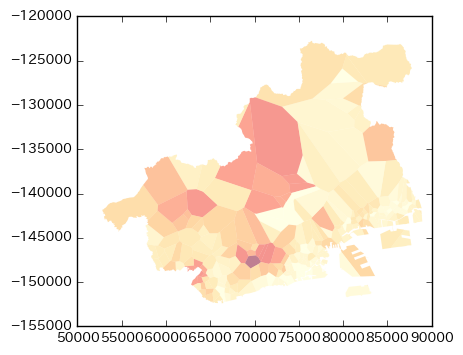

In [19]:
_ = g.plot(column="rate", cmap="YlOrRd", linewidth=0)
_ = open("../docs/data/2016-10-03-preschool-4.kml","w",encoding="UTF-8").write(kmlstr(g))
_ = open("../docs/data/2016-10-03-preschool-4.csv","w",encoding="UTF-8").write(kmlextra(g).to_csv())

## 5歳

In [20]:
g = proc("5歳", "状況,申込児童数 ５歳児").dropna()

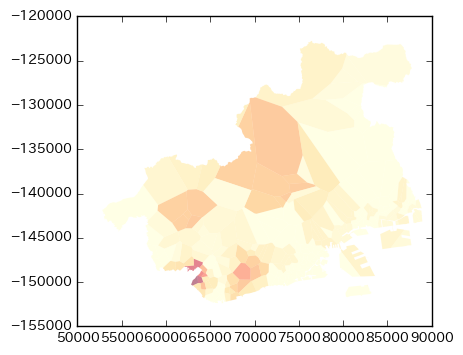

In [21]:
_ = g.plot(column="rate", cmap="YlOrRd", linewidth=0)
_ = open("../docs/data/2016-10-03-preschool-5.kml","w",encoding="UTF-8").write(kmlstr(g))
_ = open("../docs/data/2016-10-03-preschool-5.csv","w",encoding="UTF-8").write(kmlextra(g).to_csv())